In [ ]:
# !conda install -c conda-forge cairosvg pycairo
# !conda install -c anaconda tk
!pip install flatland-rl

     |████████████████████████████████| 3.3MB 5.8MB/s 
  Using cached https://files.pythonhosted.org/packages/e0/79/5915b9dad867e89bb6495456acfe5d4e2287e74dfa29c059f7b127d5480e/tox-3.20.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/70/c7/e8cb4a537ee4fc497ac80a606a667fd1832f28ad3ddbfa25bf30473eae13/pytest-4.6.11-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/16/45/81b5262c0efc08882bdf183b788e6d28e3d684863990996d8b60967d48da/pytest_runner-5.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0c/ee/55912b05af8994a190280e3281a18720f8d69da02dcb7ff44e1b96974345/crowdai_api-0.1.22.tar.gz
  Using cached https://files.pythonhosted.org/packages/60/9a/835ba329e31aa471a5597c733f7ca0136b3a0622ce01b9e66b40f5909da4/recordtype-1.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/92/7e/ae9e91c1bb8d846efafd1f353476e3fd7309778b582d2fb4cea4cc15b9a2/msgpack-0.6.1-cp36-cp36m-manylinux1_x86_64.wh

In [ ]:
import random
import sys
import copy
import os
import pickle

from argparse import ArgumentParser, Namespace
from collections import namedtuple, deque, Iterable
from pathlib import Path

# base_dir = Path(__file__).resolve().parent.parent
# sys.path.append(str(base_dir))

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
from flatland.envs.observations import TreeObsForRailEnv


In [ ]:



class DuelingQNetwork(nn.Module):
    """Dueling Q-network (https://arxiv.org/abs/1511.06581)"""

    def __init__(self, state_size, action_size, hidsize1=128, hidsize2=128):
        super(DuelingQNetwork, self).__init__()

        # value network
        self.fc1_val = nn.Linear(state_size, hidsize1)
        self.fc2_val = nn.Linear(hidsize1, hidsize2)
        self.fc4_val = nn.Linear(hidsize2, 1)

        # advantage network
        self.fc1_adv = nn.Linear(state_size, hidsize1)
        self.fc2_adv = nn.Linear(hidsize1, hidsize2)
        self.fc4_adv = nn.Linear(hidsize2, action_size)

    def forward(self, x):
        val = F.relu(self.fc1_val(x))
        val = F.relu(self.fc2_val(val))
        val = self.fc4_val(val)

        # advantage calculation
        adv = F.relu(self.fc1_adv(x))
        adv = F.relu(self.fc2_adv(adv))
        adv = self.fc4_adv(adv)

        return val + adv - adv.mean()






In [ ]:
Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, device):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.device = device

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = Experience(np.expand_dims(state, 0), action, reward, np.expand_dims(next_state, 0), done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(self.__v_stack_impr([e.state for e in experiences if e is not None])) \
            .float().to(self.device)
        actions = torch.from_numpy(self.__v_stack_impr([e.action for e in experiences if e is not None])) \
            .long().to(self.device)
        rewards = torch.from_numpy(self.__v_stack_impr([e.reward for e in experiences if e is not None])) \
            .float().to(self.device)
        next_states = torch.from_numpy(self.__v_stack_impr([e.next_state for e in experiences if e is not None])) \
            .float().to(self.device)
        dones = torch.from_numpy(self.__v_stack_impr([e.done for e in experiences if e is not None]).astype(np.uint8)) \
            .float().to(self.device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

    def __v_stack_impr(self, states):
        sub_dim = len(states[0][0]) if isinstance(states[0], Iterable) else 1
        np_states = np.reshape(np.array(states), (len(states), sub_dim))
        return np_states


In [ ]:
class Policy:
    def step(self, state, action, reward, next_state, done):
        raise NotImplementedError

    def act(self, state, eps=0.):
        raise NotImplementedError

    def save(self, filename):
        raise NotImplementedError

    def load(self, filename):
        raise NotImplementedError


class DDDQNPolicy(Policy):
    """Dueling Double DQN policy"""

    def __init__(self, state_size, action_size, parameters, evaluation_mode=False):
        self.evaluation_mode = evaluation_mode

        self.state_size = state_size
        self.action_size = action_size
        self.double_dqn = True
        self.hidsize = 1

        if not evaluation_mode:
            self.hidsize = parameters.hidden_size
            self.buffer_size = parameters.buffer_size
            self.batch_size = parameters.batch_size
            self.update_every = parameters.update_every
            self.learning_rate = parameters.learning_rate
            self.tau = parameters.tau
            self.gamma = parameters.gamma
            self.buffer_min_size = parameters.buffer_min_size

        # Device
        if parameters.use_gpu and torch.cuda.is_available():
            self.device = torch.device("cuda:0")
            # print("🐇 Using GPU")
        else:
            self.device = torch.device("cpu")
            # print("🐢 Using CPU")

        # Q-Network
        self.qnetwork_local = DuelingQNetwork(state_size, action_size, hidsize1=self.hidsize, hidsize2=self.hidsize).to(self.device)

        if not evaluation_mode:
            self.qnetwork_target = copy.deepcopy(self.qnetwork_local)
            self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.learning_rate)
            self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, self.device)

            self.t_step = 0
            self.loss = 0.0

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def step(self, state, action, reward, next_state, done):
        assert not self.evaluation_mode, "Policy has been initialized for evaluation only."

        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.buffer_min_size and len(self.memory) > self.batch_size:
                self._learn()

    def _learn(self):
        experiences = self.memory.sample()
        states, actions, rewards, next_states, dones = experiences

        # Get expected Q values from local model
        q_expected = self.qnetwork_local(states).gather(1, actions)

        if self.double_dqn:
            # Double DQN
            q_best_action = self.qnetwork_local(next_states).max(1)[1]
            q_targets_next = self.qnetwork_target(next_states).gather(1, q_best_action.unsqueeze(-1))
        else:
            # DQN
            q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(-1)

        # Compute Q targets for current states
        q_targets = rewards + (self.gamma * q_targets_next * (1 - dones))

        # Compute loss
        self.loss = F.mse_loss(q_expected, q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()

        # Update target network
        self._soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def _soft_update(self, local_model, target_model, tau):
        # Soft update model parameters.
        # θ_target = τ*θ_local + (1 - τ)*θ_target
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

    def save(self, filename):
        torch.save(self.qnetwork_local.state_dict(), filename + ".local")
        torch.save(self.qnetwork_target.state_dict(), filename + ".target")

    def load(self, filename):
        if os.path.exists(filename + ".local"):
            self.qnetwork_local.load_state_dict(torch.load(filename + ".local"))
        if os.path.exists(filename + ".target"):
            self.qnetwork_target.load_state_dict(torch.load(filename + ".target"))

    def save_replay_buffer(self, filename):
        memory = self.memory.memory
        with open(filename, 'wb') as f:
            pickle.dump(list(memory)[-500000:], f)

    def load_replay_buffer(self, filename):
        with open(filename, 'rb') as f:
            self.memory.memory = pickle.load(f)

    def test(self):
        self.act(np.array([[0] * self.state_size]))
        self._learn()


In [ ]:

def max_lt(seq, val):
    """
    Return greatest item in seq for which item < val applies.
    None is returned if seq was empty or all items in seq were >= val.
    """
    max = 0
    idx = len(seq) - 1
    while idx >= 0:
        if seq[idx] < val and seq[idx] >= 0 and seq[idx] > max:
            max = seq[idx]
        idx -= 1
    return max


def min_gt(seq, val):
    """
    Return smallest item in seq for which item > val applies.
    None is returned if seq was empty or all items in seq were >= val.
    """
    min = np.inf
    idx = len(seq) - 1
    while idx >= 0:
        if seq[idx] >= val and seq[idx] < min:
            min = seq[idx]
        idx -= 1
    return min


def norm_obs_clip(obs, clip_min=-1, clip_max=1, fixed_radius=0, normalize_to_range=False):
    """
    This function returns the difference between min and max value of an observation
    :param obs: Observation that should be normalized
    :param clip_min: min value where observation will be clipped
    :param clip_max: max value where observation will be clipped
    :return: returnes normalized and clipped observatoin
    """
    if fixed_radius > 0:
        max_obs = fixed_radius
    else:
        max_obs = max(1, max_lt(obs, 1000)) + 1

    min_obs = 0  # min(max_obs, min_gt(obs, 0))
    if normalize_to_range:
        min_obs = min_gt(obs, 0)
    if min_obs > max_obs:
        min_obs = max_obs
    if max_obs == min_obs:
        return np.clip(np.array(obs) / max_obs, clip_min, clip_max)
    norm = np.abs(max_obs - min_obs)
    return np.clip((np.array(obs) - min_obs) / norm, clip_min, clip_max)


def _split_node_into_feature_groups(node) -> (np.ndarray, np.ndarray, np.ndarray):
    data = np.zeros(6)
    distance = np.zeros(1)
    agent_data = np.zeros(4)

    data[0] = node.dist_own_target_encountered
    data[1] = node.dist_other_target_encountered
    data[2] = node.dist_other_agent_encountered
    data[3] = node.dist_potential_conflict
    data[4] = node.dist_unusable_switch
    data[5] = node.dist_to_next_branch

    distance[0] = node.dist_min_to_target

    agent_data[0] = node.num_agents_same_direction
    agent_data[1] = node.num_agents_opposite_direction
    agent_data[2] = node.num_agents_malfunctioning
    agent_data[3] = node.speed_min_fractional

    return data, distance, agent_data


def _split_subtree_into_feature_groups(node, current_tree_depth: int, max_tree_depth: int) -> (np.ndarray, np.ndarray, np.ndarray):
    if node == -np.inf:
        remaining_depth = max_tree_depth - current_tree_depth
        # reference: https://stackoverflow.com/questions/515214/total-number-of-nodes-in-a-tree-data-structure
        num_remaining_nodes = int((4 ** (remaining_depth + 1) - 1) / (4 - 1))
        return [-np.inf] * num_remaining_nodes * 6, [-np.inf] * num_remaining_nodes, [-np.inf] * num_remaining_nodes * 4

    data, distance, agent_data = _split_node_into_feature_groups(node)

    if not node.childs:
        return data, distance, agent_data

    for direction in TreeObsForRailEnv.tree_explored_actions_char:
        sub_data, sub_distance, sub_agent_data = _split_subtree_into_feature_groups(node.childs[direction], current_tree_depth + 1, max_tree_depth)
        data = np.concatenate((data, sub_data))
        distance = np.concatenate((distance, sub_distance))
        agent_data = np.concatenate((agent_data, sub_agent_data))

    return data, distance, agent_data


def split_tree_into_feature_groups(tree, max_tree_depth: int) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    This function splits the tree into three difference arrays of values
    """
    data, distance, agent_data = _split_node_into_feature_groups(tree)

    for direction in TreeObsForRailEnv.tree_explored_actions_char:
        sub_data, sub_distance, sub_agent_data = _split_subtree_into_feature_groups(tree.childs[direction], 1, max_tree_depth)
        data = np.concatenate((data, sub_data))
        distance = np.concatenate((distance, sub_distance))
        agent_data = np.concatenate((agent_data, sub_agent_data))

    return data, distance, agent_data


def normalize_observation(observation, tree_depth: int, observation_radius=0):
    """
    This function normalizes the observation used by the RL algorithm
    """
    data, distance, agent_data = split_tree_into_feature_groups(observation, tree_depth)

    data = norm_obs_clip(data, fixed_radius=observation_radius)
    distance = norm_obs_clip(distance, normalize_to_range=True)
    agent_data = np.clip(agent_data, -1, 1)
    normalized_obs = np.concatenate((np.concatenate((data, distance)), agent_data))
    return normalized_obs


In [ ]:

def train_agent(n_episodes):
    # Environment parameters
    n_agents = 1
    x_dim = 50
    y_dim = 50
    n_cities = 5
    max_rails_between_cities = 4
    max_rails_in_city = 9
    seed = 42

    # Observation parameters
    observation_tree_depth = 4
    observation_radius = 10

    # Exploration parameters
    eps_start = 1.0
    eps_end = 0.01
    eps_decay = 0.997  # for 2500ts

    # Set the seeds
    random.seed(seed)
    np.random.seed(seed)

    # Observation builder
    tree_observation = TreeObsForRailEnv(max_depth=observation_tree_depth)

    # Setup the environment
    env = RailEnv(
        width=x_dim,
        height=y_dim,
        rail_generator=sparse_rail_generator(
            max_num_cities=n_cities,
            seed=seed,
            grid_mode=False,
            max_rails_between_cities=max_rails_between_cities,
            max_rails_in_city=max_rails_in_city
        ),
        schedule_generator=sparse_schedule_generator(),
        number_of_agents=n_agents,
        obs_builder_object=tree_observation
    )

    env.reset(True, True)

    # Calculate the state size given the depth of the tree observation and the number of features
    n_features_per_node = env.obs_builder.observation_dim
    n_nodes = 0
    for i in range(observation_tree_depth + 1):
        n_nodes += np.power(4, i)
    state_size = n_features_per_node * n_nodes

    # The action space of flatland is 5 discrete actions
    action_size = 5

    # Max number of steps per episode
    # This is the official formula used during evaluations
    max_steps = int(4 * 2 * (env.height + env.width + (n_agents / n_cities)))

    action_dict = dict()

    # And some variables to keep track of the progress
    scores_window = deque(maxlen=100)  # todo smooth when rendering instead
    completion_window = deque(maxlen=100)
    scores = []
    completion = []
    action_count = [0] * action_size
    agent_obs = [None] * env.get_num_agents()
    agent_prev_obs = [None] * env.get_num_agents()
    agent_prev_action = [2] * env.get_num_agents()
    update_values = False

    # Training parameters
    training_parameters = {
        'buffer_size': int(1e5),
        'batch_size': 32,
        'update_every': 8,
        'learning_rate': 0.5e-4,
        'tau': 1e-3,
        'gamma': 0.99,
        'buffer_min_size': 0,
        'hidden_size': 256,
        'use_gpu': False
    }

    # Double Dueling DQN policy
    policy = DDDQNPolicy(state_size, action_size, Namespace(**training_parameters))

    for episode_idx in range(1, n_episodes + 1):
        score = 0

        # Reset environment
        obs, info = env.reset(regenerate_rail=True, regenerate_schedule=True)

        # Build agent specific observations
        for agent in env.get_agent_handles():
            if obs[agent]:
                agent_obs[agent] = normalize_observation(obs[agent], observation_tree_depth, observation_radius=observation_radius)
                agent_prev_obs[agent] = agent_obs[agent].copy()

        # Run episode
        for step in range(max_steps - 1):
            for agent in env.get_agent_handles():
                if info['action_required'][agent]:
                    # If an action is required, we want to store the obs at that step as well as the action
                    update_values = True
                    action = policy.act(agent_obs[agent], eps=eps_start)
                    action_count[action] += 1
                else:
                    update_values = False
                    action = 0
                action_dict.update({agent: action})

            # Environment step
            next_obs, all_rewards, done, info = env.step(action_dict)

            # Update replay buffer and train agent
            for agent in range(env.get_num_agents()):
                # Only update the values when we are done or when an action was taken and thus relevant information is present
                if update_values or done[agent]:
                    policy.step(agent_prev_obs[agent], agent_prev_action[agent], all_rewards[agent], agent_obs[agent], done[agent])

                    agent_prev_obs[agent] = agent_obs[agent].copy()
                    agent_prev_action[agent] = action_dict[agent]

                if next_obs[agent]:
                    agent_obs[agent] = normalize_observation(next_obs[agent], observation_tree_depth, observation_radius=10)

                score += all_rewards[agent]

            if done['__all__']:
                break

        # Epsilon decay
        eps_start = max(eps_end, eps_decay * eps_start)

        # Collection information about training
        tasks_finished = np.sum([int(done[idx]) for idx in env.get_agent_handles()])
        completion_window.append(tasks_finished / max(1, env.get_num_agents()))
        scores_window.append(score / (max_steps * env.get_num_agents()))
        completion.append((np.mean(completion_window)))
        scores.append(np.mean(scores_window))
        action_probs = action_count / np.sum(action_count)

        if episode_idx % 100 == 0:
            end = "\n"
            torch.save(policy.qnetwork_local, './checkpoints/single-' + str(episode_idx) + '.pth')
            action_count = [1] * action_size
        else:
            end = " "

        print('\rTraining {} agents on {}x{}\t Episode {}\t Average Score: {:.3f}\tDones: {:.2f}%\tEpsilon: {:.2f} \t Action Probabilities: \t {}'.format(
            env.get_num_agents(),
            x_dim, y_dim,
            episode_idx,
            np.mean(scores_window),
            100 * np.mean(completion_window),
            eps_start,
            action_probs
        ), end=end)

    # Plot overall training progress at the end
    plt.plot(scores)
    plt.show()

    plt.plot(completion)
    plt.show()


/usr/local/lib/python3.6/dist-packages/flatland/envs/rail_generators.py:781: UserWarning: Could not set all required cities!
  "Could not set all required cities!")


Training 1 agents on 50x50	 Episode 100	 Average Score: -0.677	Dones: 51.00%	Epsilon: 0.74 	 Action Probabilities: 	 [0.19889543 0.2035162  0.19525037 0.20392121 0.19841679]
Training 1 agents on 50x50	 Episode 200	 Average Score: -0.612	Dones: 60.00%	Epsilon: 0.55 	 Action Probabilities: 	 [0.17614862 0.21615187 0.19641476 0.2361942  0.17509055]
Training 1 agents on 50x50	 Episode 300	 Average Score: -0.450	Dones: 74.00%	Epsilon: 0.41 	 Action Probabilities: 	 [0.17362492 0.22840733 0.20855423 0.25505302 0.1343605 ]
Training 1 agents on 50x50	 Episode 400	 Average Score: -0.348	Dones: 86.00%	Epsilon: 0.30 	 Action Probabilities: 	 [0.16076838 0.26668805 0.23015788 0.23464842 0.10773727]
Training 1 agents on 50x50	 Episode 500	 Average Score: -0.312	Dones: 88.00%	Epsilon: 0.22 	 Action Probabilities: 	 [0.14476402 0.28766089 0.21126649 0.23248053 0.12382806]
Training 1 agents on 50x50	 Episode 600	 Average Score: -0.222	Dones: 97.00%	Epsilon: 0.16 	 Action Probabilities: 	 [0.12827794 0

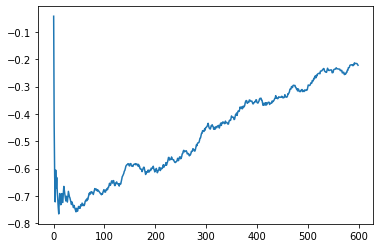

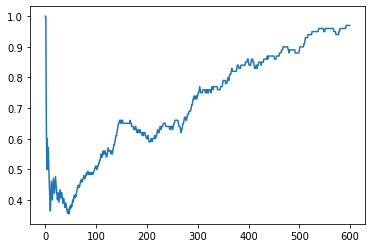

In [ ]:
n_episodes = 600

train_agent(n_episodes)